# <font color="red">VQ1 Codebook Hierarchical Clustering and Feature Spectra<font/>
    Notebook for running the feature spectra analysis.
    First, the data (vqindhist) is loaded from the train batches; Then, we create the codebook heatmap: group by marker and average the histograms, calculate correlations on the columns (codewords), run hierarchical clustering. Then, the threshold for the clusters need to be selected manually. Then we can find representative images and create the clustermaps and histograms as we want.

In [1]:
import os
import sys

import scipy
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import warnings

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist
from scipy.stats import spearmanr, pearsonr

%matplotlib inline
%reload_ext autoreload
%autoreload 2
%aimport

os.environ['MOMAPS_HOME'] = '/home/labs/hornsteinlab/Collaboration/MOmaps_Noam/MOmaps'
sys.path.insert(1, os.getenv('MOMAPS_HOME'))
from src.common.lib.feature_spectra_utils import *

warnings.filterwarnings('ignore')



Modules to reload:
all-except-skipped

Modules to skip:



## Model, Embeddings and Output folder

In [2]:
MODEL_PATH = '/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/models_outputs_batch78_nods_tl_ep23/'
EMBEDDINGS_FOLDER = os.path.join(MODEL_PATH, 'embeddings', 'neurons', 'vqindhist1')
SAVE_PATH_fig2 = '/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/manuscript/fig2'
SAVE_PATH_fig3 = '/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/manuscript/fig3'
SAVE_PATH_fig5 = '/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/manuscript/fig5'


## Load vqindhist of batch 7&8

In [3]:
vqindhist, labels, paths = load_multiple_vqindhists(batches=['batch7','batch8'], 
                                                    embeddings_folder=EMBEDDINGS_FOLDER, 
                                                    datasets=['trainset'])


## Convert the histograms to a dataframe (hist_df) and add the label and path

In [4]:
hist_df = create_vqindhists_df(vqindhist, labels, paths)
print(hist_df.shape)
hist_df.sample(5)

(574310, 2050)


0    1    2    3    4    5    6    7    8    9  ...  2040  2041  \
364209  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   0.0   0.0   
572338  1.0  0.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   1.0   0.0   
396789  1.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...   0.0   0.0   
17529   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  17.0   0.0   
144837  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...   0.0   0.0   

        2042  2043  2044  2045  2046  2047  \
364209   0.0   0.0   1.0   0.0   0.0   0.0   
572338   0.0   0.0   0.0   0.0   0.0   0.0   
396789   0.0   0.0   0.0   0.0   0.0   0.0   
17529    0.0   0.0   0.0   3.0   0.0   0.0   
144837   0.0   1.0   0.0   0.0   0.0   5.0   

                                                     path  \
364209  /home/labs/hornsteinlab/Collaboration/MOmaps/i...   
572338  /home/labs/hornsteinlab/Collaboration/MOmaps/i...   
396789  /home/labs/hornsteinlab/Collaboration/MOmaps/i...   
17529   /home/labs/hornsteinlab/Collaboration/MOmaps/i...   
144837  /home/labs/hornsteinlab/Collaboration/MOmaps/i...   

                                           label  
364209   DAPI_FUSRevertant_Untreated_batch8_rep1  
572338            NCL_TBK1_Untreated_batch8_rep2  
396789          KIF5A_TBK1_Untreated_batch8_rep1  
17529           GM130_OPTN_Untreated_batch7_rep1  
144837  PSD95_FUSRevertant_Untreated_batch7_rep2  

[5 rows x 2050 columns]

# <font color="purple">Clustering of codebook vectors calculation step<font/>
## <font color="gray">Filter cell line, condition and markers<font/>

In [5]:
hist_df_wt = hist_df[hist_df.label.str.contains('WT')] # & hist_df.label.str.contains('Untreated')
print(hist_df_wt.shape)
hist_df_wt = hist_df_wt[~hist_df_wt.label.str.contains('TIA1|FMRP', regex=True)] 
print(hist_df_wt.shape)
hist_df_wt.sample(5)


(136993, 2050)
(133103, 2050)


0    1     2    3     4    5    6    7    8    9  ...  2040  2041  \
416992  0.0  1.0  16.0  1.0   0.0  0.0  0.0  0.0  0.0  0.0  ...   1.0   0.0   
17164   0.0  0.0   0.0  1.0  12.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
353149  0.0  0.0   1.0  0.0   2.0  0.0  0.0  0.0  0.0  0.0  ...   4.0   0.0   
137911  0.0  0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...   1.0   0.0   
548864  0.0  0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  ...   1.0   0.0   

        2042  2043  2044  2045  2046  2047  \
416992   0.0   0.0   0.0   1.0   0.0   0.0   
17164    0.0   0.0   0.0   3.0   0.0   0.0   
353149   0.0   0.0   0.0   0.0   0.0   0.0   
137911   0.0   0.0   1.0   0.0   0.0   0.0   
548864   0.0   0.0   0.0   0.0   0.0   0.0   

                                                     path  \
416992  /home/labs/hornsteinlab/Collaboration/MOmaps/i...   
17164   /home/labs/hornsteinlab/Collaboration/MOmaps/i...   
353149  /home/labs/hornsteinlab/Collaboration/MOmaps/i...   
137911  /home/labs/hornsteinlab/Collaboration/MOmaps/i...   
548864  /home/labs/hornsteinlab/Collaboration/MOmaps/i...   

                                  label  
416992   KIF5A_WT_Untreated_batch8_rep1  
17164    LAMP1_WT_Untreated_batch7_rep2  
353149  TOMM20_WT_Untreated_batch8_rep2  
137911      PEX14_WT_stress_batch7_rep1  
548864    DAPI_WT_Untreated_batch8_rep1  

[5 rows x 2050 columns]

Computing pearson correlation of 192 labels based on 2048 codebook vectors


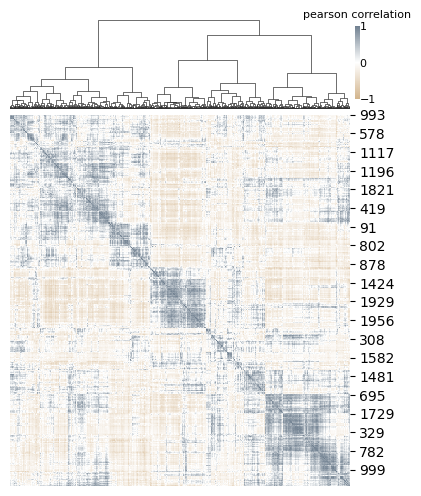

In [6]:
# Correlate codebook vectors (heatmap)
clustermap, codebook_corr = create_codebook_heatmap(hist_df_wt.drop(columns='path'), 
                                                            corr_method='pearson', 
                                                            calc_linkage=True, 
                                                            linkage_method='ward' #'complete', 'average', 'median', 'ward'
                                                           )


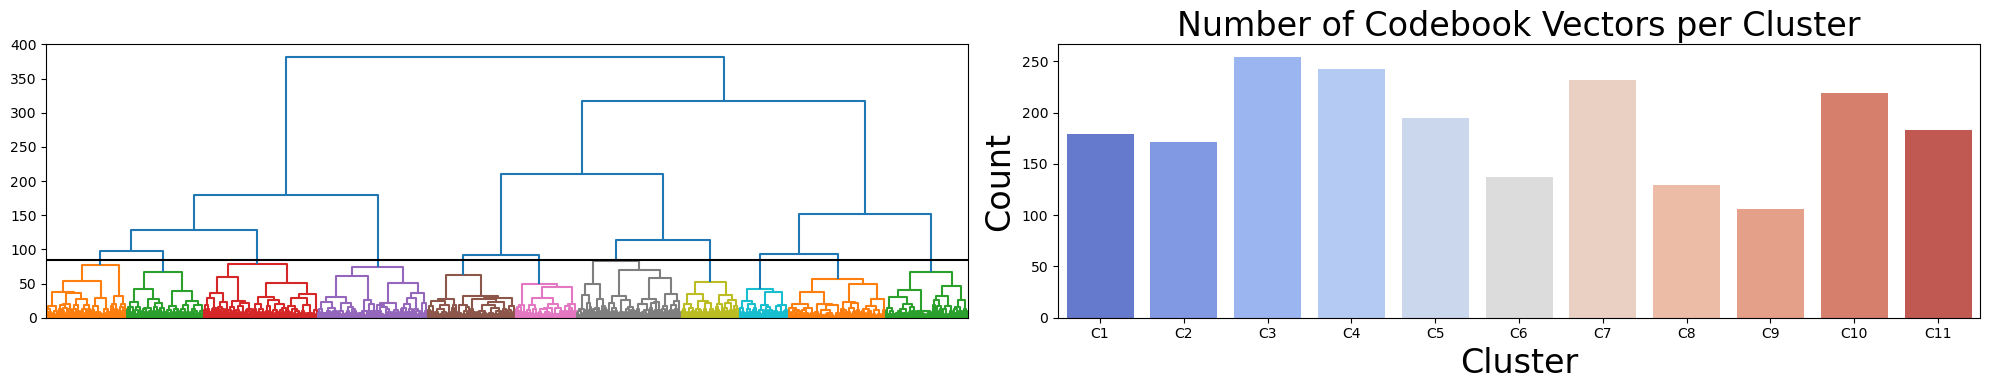

In [7]:
# decide on num of clusters by dendogram (and number of codebook vectors in each cluster)
corr_with_clusters = set_num_clusters_by_dendrogram(clustermap, 
                                                    codebook_corr, 
                                                    cutoff=84)

# Fetch the cluster assignment of each codebook vector
codebook_vec_cluster_assignment = corr_with_clusters[['cluster']]


# <font color="purple"> Find representative images per cluster </font>

Showing more than one label = True


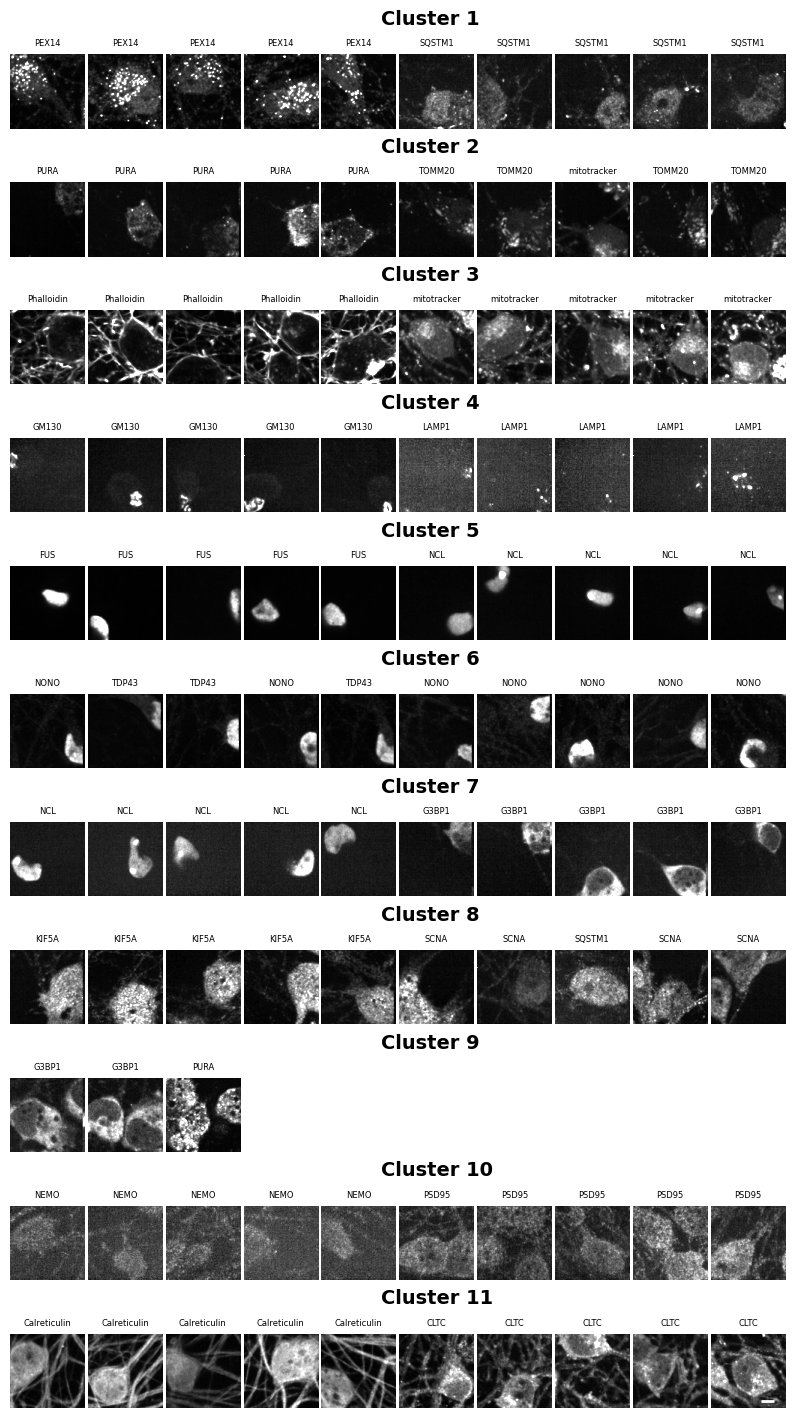

In [43]:
# remove DAPI from representative images
hist_df_wt_no_dapi = hist_df_wt[~hist_df_wt.label.str.contains('DAPI')] 
print(hist_df_wt_no_dapi.shape)


# Retuns max cluster for each tile AKA assigns tile images to clusters 
tile_score_per_cluster = find_max_cluster_per_tile(codebook_vec_cluster_assignment, 
                                                   hist_df_wt_no_dapi, 
                                                   norm_by='cluster_size')

# Plot the tiles per cluster (and condition, optional)
rep_tiles_per_cluster = plot_representative_tiles(tile_score_per_cluster,  
                                                  by_conditions=['Untreated'], 
                                                  show_other_labels=True, 
                                                  # figsize=(16,5), plot_for_notebook=True, top_images=16, # version for the notebook plot
                                                  figsize=(10,18), plot_for_notebook=False, top_images=10, # version for the saving plot
                                                 save_path = SAVE_PATH_fig3)

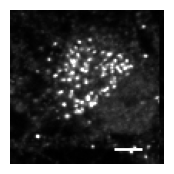

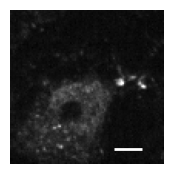

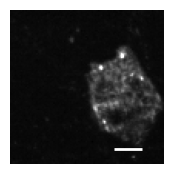

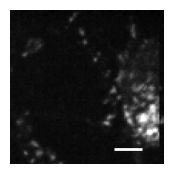

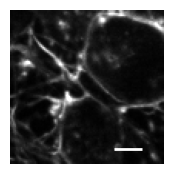

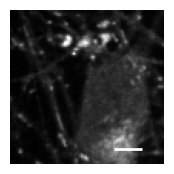

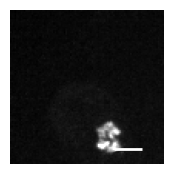

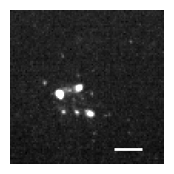

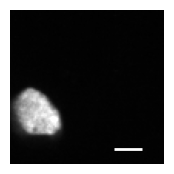

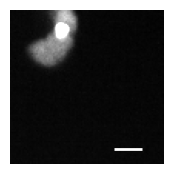

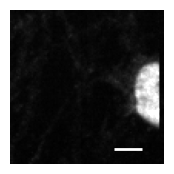

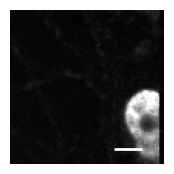

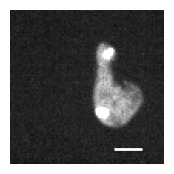

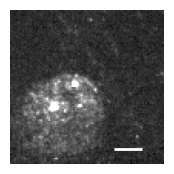

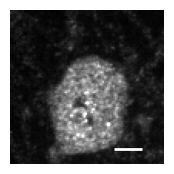

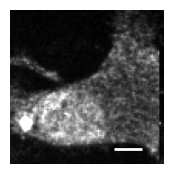

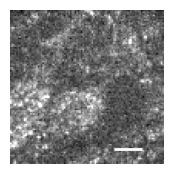

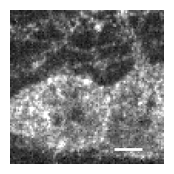

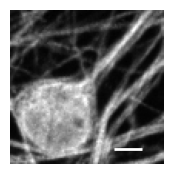

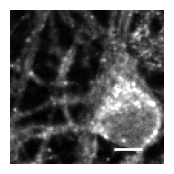

In [23]:
# Choose represntative images
chosen_idx_dict = {}
chosen_idx_dict[1] = [[1,12]]
chosen_idx_dict[2] = [[1,14]]
chosen_idx_dict[3] = [[3,14]]
chosen_idx_dict[4] = [[1,12]]
chosen_idx_dict[5] = [[4,9]]
chosen_idx_dict[6] = [[2,3]]
chosen_idx_dict[7] = [[1,13]]
chosen_idx_dict[8] = [[5,15]]
chosen_idx_dict[10] = [[2,8]]
chosen_idx_dict[11] = [[1,8]]
save_representative_tiles(rep_tiles_per_cluster, chosen_idx_dict, to_save=True, save_path=SAVE_PATH_fig2)

#### Label per cluster

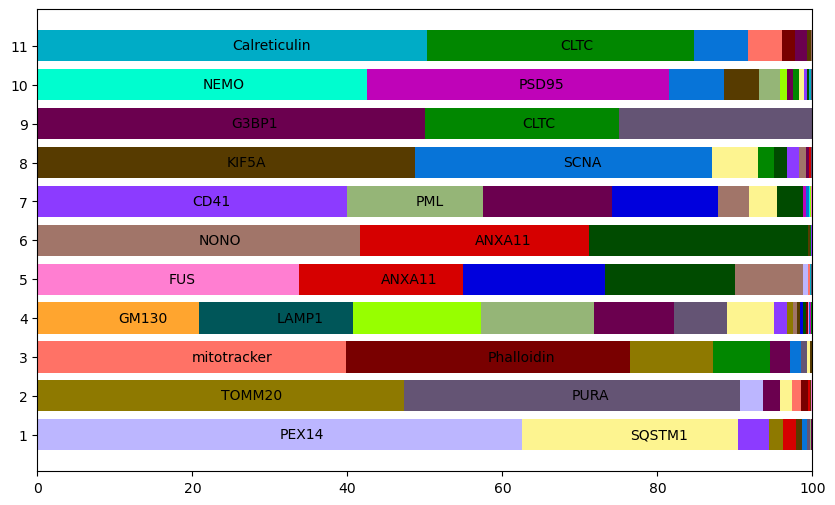

In [9]:
plot_tile_label_pct_in_cluster(tile_score_per_cluster)

# <font color="purple"> heatmap and histograms </font>

## Load vqindhist of inference batches

In [8]:
## Load other batches vqindhists
vqindhist_all, labels_all, paths_all = load_multiple_vqindhists(batches = [f'batch{i}' for i in [6]], embeddings_folder = EMBEDDINGS_FOLDER, 
                                                    datasets = ['all'])

In [9]:
## Add also batches 7+8
vqindhist_all = vqindhist_all + vqindhist
labels_all = labels_all + labels
paths_all = paths_all + paths

## Convert the histograms to a dataframe (hist_df) and add the label and path

In [10]:
## Unite all data in df
hist_df_all = create_vqindhists_df(vqindhist_all, labels_all, paths_all)
#hist_df_all.sample(5)

## Combine different batch&rep to unified labels

In [11]:
# Prepare data for hisograms
hist_df_all_wt_untreated = hist_df_all[hist_df_all.label.str.contains('WT_Untreated')] # taking only wt untreated
hist_df_all_wt_untreated = hist_df_all_wt_untreated[~hist_df_all_wt_untreated.label.str.contains('TIA1|FMRP', regex=True)] # remove unwanted markers
hist_df_all_wt_untreated_agg = hist_df_all_wt_untreated.copy()
hist_df_all_wt_untreated_agg['label'] = hist_df_all_wt_untreated_agg['label'].str.split("_").str[0] # merging different batches and reps -> label == marker
hist_df_all_wt_untreated_agg = hist_df_all_wt_untreated_agg.drop(columns='path')
print(hist_df_all_wt_untreated_agg.shape)
# Prepare for showing delta
hist_df_all_wt = hist_df_all[hist_df_all.label.str.contains('WT')] # taking only wt untreated
hist_df_all_wt = hist_df_all_wt[~hist_df_all_wt.label.str.contains('TIA1|FMRP', regex=True)] # remove unwanted markers
hist_df_all_wt_agg = hist_df_all_wt.copy()
hist_df_all_wt_agg
hist_df_all_wt_agg['label'] = hist_df_all_wt_agg['label'].str.split("_").str[0:3:2].apply(lambda x: '_'.join(x)) # merging different batches and reps -> label == marker_cond
hist_df_all_wt_agg = hist_df_all_wt_agg.drop(columns='path')
print(hist_df_all_wt_agg.shape)


(120002, 2049)
(236208, 2049)


In [125]:
### THIS IS SKIPPED CURRENTLY
# ## Correlate marker histograms to get marker order
# hist_df_all_wt_untreated_average = hist_df_all_wt_untreated_agg.groupby('label').mean()
# marker_order, _ = create_lables_heatmap(hist_df_all_wt_untreated_average, 'Marker Correlation (WT)')

In [130]:
marker_order = [# Cytoplasm category
                'CLTC', 'Calreticulin', 'KIF5A', 'SCNA', 'NEMO', 'PSD95',
                # Nuclear category
                'ANXA11','TDP43', 'NONO', 'FUS','DAPI', 'NCL', 
                # Dotted category
                'mitotracker', 'PEX14', 'TOMM20', 'PURA', 'GM130', 'LAMP1', 'PML', 'SQSTM1', 'CD41', 'DCP1A', 'G3BP1', 'Phalloidin'
               ]


## WT Untreated heatmap and histograms

labels: ['CLTC', 'Calreticulin', 'KIF5A', 'SCNA', 'NEMO', 'PSD95', 'ANXA11', 'TDP43', 'NONO', 'FUS', 'DAPI', 'NCL', 'mitotracker', 'PEX14', 'TOMM20', 'PURA', 'GM130', 'LAMP1', 'PML', 'SQSTM1', 'CD41', 'DCP1A', 'G3BP1', 'Phalloidin']
 total labels: ['ANXA11' 'CD41' 'CLTC' 'Calreticulin' 'DAPI' 'DCP1A' 'FUS' 'G3BP1'
 'GM130' 'KIF5A' 'LAMP1' 'NCL' 'NEMO' 'NONO' 'PEX14' 'PML' 'PSD95' 'PURA'
 'Phalloidin' 'SCNA' 'SQSTM1' 'TDP43' 'TOMM20' 'mitotracker']


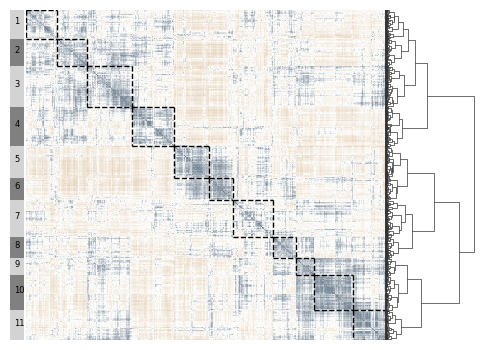

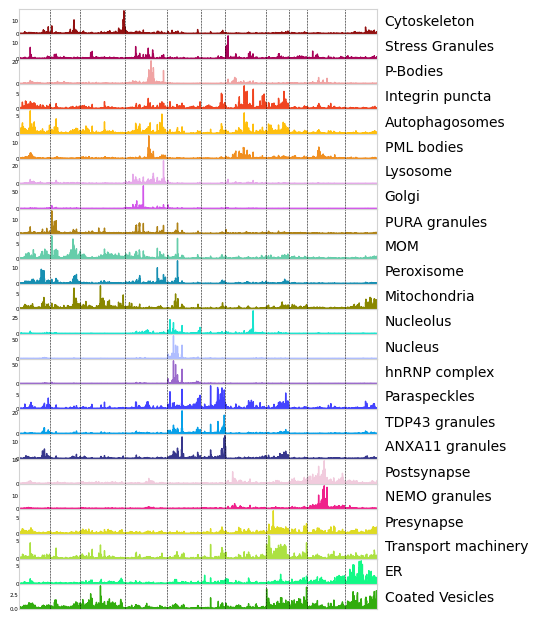

In [131]:

plot_heatmap_with_clusters_and_histograms(corr_with_clusters.sort_index(), 
                                          hist_df_all_wt_untreated_agg, 
                                          labels=list(marker_order), save_path=SAVE_PATH_fig2, plot_hists=False, sep_histograms=True,
                                          to_save=True, hist_filename = "wt_untreated_FS_hists.eps", heatmap_filename="wt_untreated_FS_heatmap.tiff",  
                                          calc_linkage=True, figsize=(5,5),
                                          linkage_method='ward')

## Correlate delta histograms and create a graph network of marker deltas

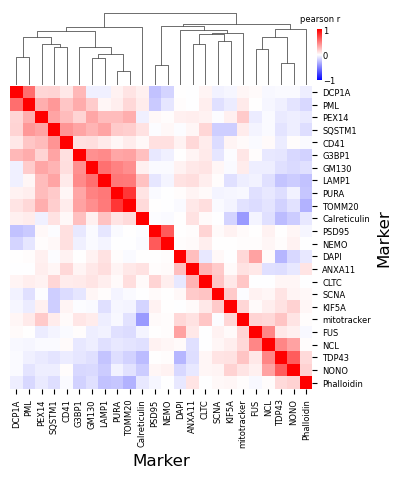

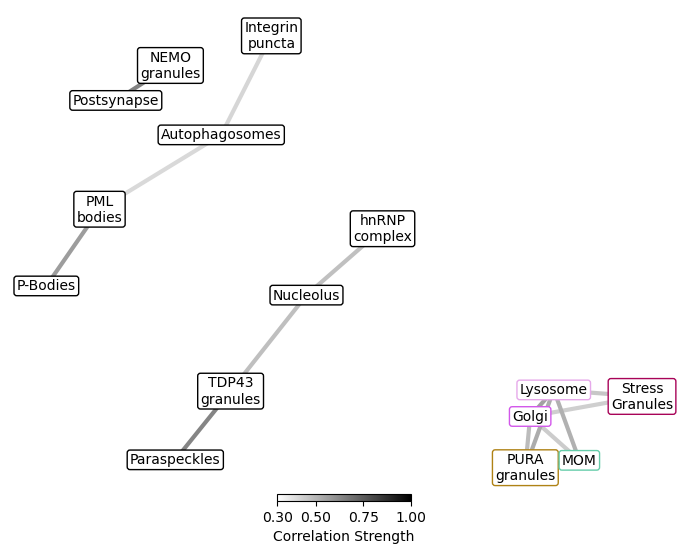

In [145]:
analyse_deltas(hist_df_all_wt_agg, first_cond='stress', second_cond='Untreated', 
                  graph_filename='delta_correlation_network_graph.eps', save_path=SAVE_PATH_fig3, 
                   to_save=False, plot_network=True, scale_factor=10,corr_method='pearson')

## WT Untreated Vs stress heatmap and histograms

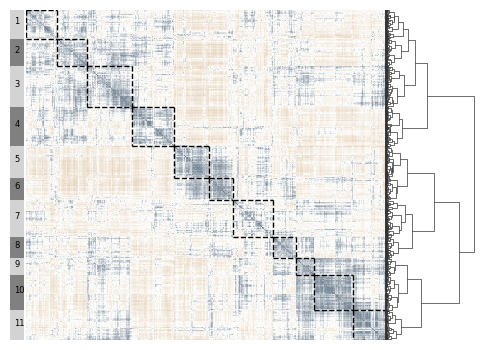

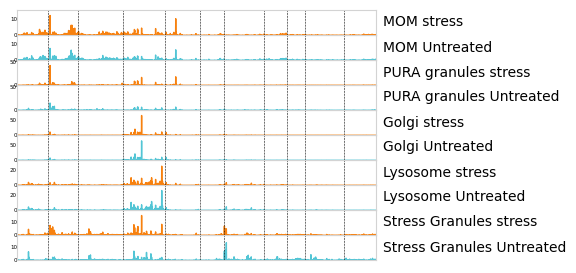

In [12]:
plot_heatmap_with_clusters_and_histograms(corr_with_clusters.sort_index(), hist_df_all_wt_agg, 
                                          labels=['G3BP1','LAMP1','GM130','PURA','TOMM20'], 
                                          save_path=SAVE_PATH_fig3, color_by_cond=True, plot_hists=False,
                                         sep_histograms=True, to_save=False, 
                                         calc_linkage=True, linkage_method='ward', figsize=(5,5),
                                         hist_filename = "wt_untreated_vs_stress_FS_hists.eps", heatmap_filename="wt_untreated_vs_stress_FS_heatmap.tiff")

## WT Untreated Vs stress DELTA heatmap and histograms

TOMM20
PURA
GM130
LAMP1
G3BP1


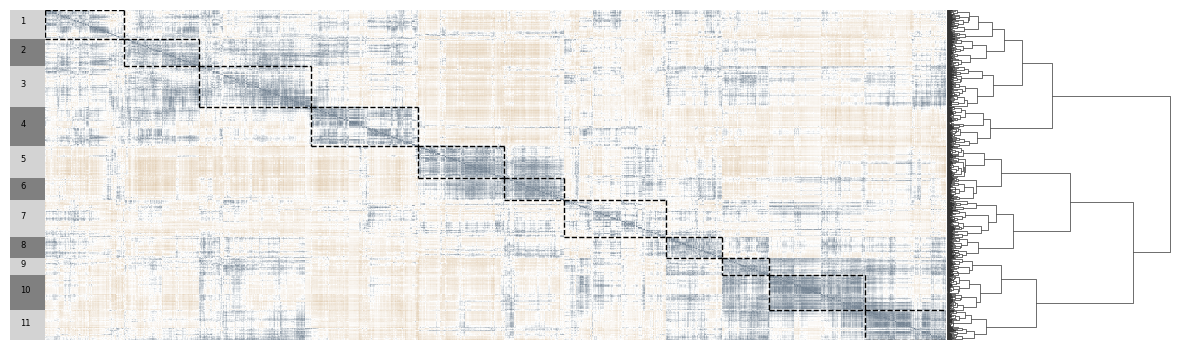

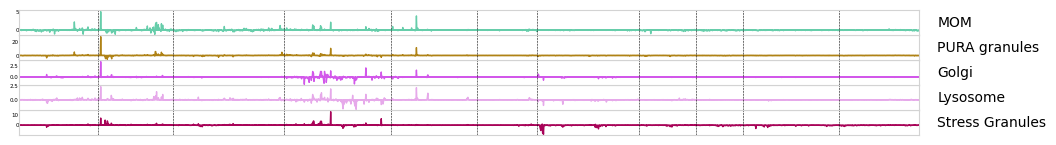

In [140]:
plot_heatmap_with_clusters_and_histograms(corr_with_clusters.sort_index(), hist_df_all_wt_agg,
                                          labels=['G3BP1','LAMP1','GM130','PURA','TOMM20'], 
                                          to_save=True,sep_histograms=True,plot_hists=False,  
                                          calc_linkage=True, linkage_method='ward',
                                          save_path=SAVE_PATH_fig3, plot_delta=True, figsize=(12,5),
                                          hist_filename = "wt_delta_FS_hists.eps", heatmap_filename="wt_delta_FS_heatmap.tiff",)

In [ ]:
# for first_cond, second_cond in zip(['FUSHeterozygous', 'FUSHomozygous','FUSHomozygous','FUSHeterozygous'],['WT_Untreated','WT_Untreated','FUSRevertant','FUSRevertant']):
#     ## Prepare data for hisograms (first vs second)
#     df = all_lines_hist_df.copy()
#     df = df[df.label.str.contains(f'{first_cond}|{second_cond}', regex=True)]  #taking only wt 
#     df['label'] = df['label'].str.split("_").str[0:2].apply(lambda x: '_'.join(x)) # merging different batches and reps -> label == marker_cellline
    
#     markers = np.unique(df['label'].str.split("_").str[0])

#     average_hist = df.groupby('label').mean()
#     deltas = pd.DataFrame(index = markers, columns=average_hist.columns)
    
#     # calc delta and save in a new df
#     for marker in markers:
#         first = average_hist.loc[f'{marker}_{first_cond}']
#         second =  average_hist.loc[f'{marker}_{second_cond.replace("_Untreated","")}']
#         deltas.loc[marker] =  first - second

#     markers_order, marker_delta_corr = create_lables_heatmap(deltas, f'Marker Correlation based on delta feature spectra of {first_cond} vs {second_cond}',
#                                          save_path=SAVE_PATH, to_save=True, filename=f"{first_cond}_vs_{second_cond}_delta_marker_correlation.png")

    
#     plot_heatmap_with_clusters_and_histograms(corr_with_clusters, df, labels=list(markers_order), 
#                                           to_save=False,
#                                           save_path=SAVE_PATH, plot_delta=True, div=False, 
#                                               filename = f"codeword_idx_heatmap_and_histograms_delta_{first_cond}_vs_{second_cond}.png",
#                                          first_cond=first_cond, 
#                                               second_cond=second_cond.replace("_Untreated",""), 
#                                               title=f'delta feature spectra of {first_cond} vs {second_cond}')
    
#     positive_graph = create_correlation_graph(marker_delta_corr, top_positive=True)
#     draw_correlation_graph(positive_graph, 'Positive Correlation Graph', cmap=plt.get_cmap('Reds'), vmin=0, vmax=1)

#     negative_graph = create_correlation_graph(marker_delta_corr, top_positive=False)
#     draw_correlation_graph(negative_graph, 'Negative Correlation Graph', cmap=plt.get_cmap('Blues_r'), vmin=-1, vmax=0)
    
    
#     graph = create_bicorrelation_graph(marker_delta_corr)
#     draw_bicorrelation_graph(graph, 'bicor', cmap_pos = plt.get_cmap('Reds'), 
#                              cmap_neg = plt.get_cmap('Blues_r'))

## FUS lines (FUS marker) vs WT (FUS & NEMO markers)

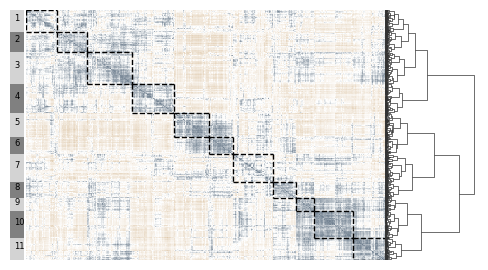

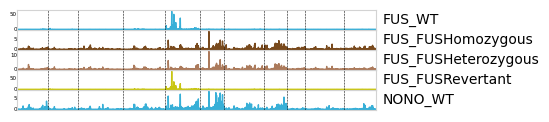

In [26]:
cell_lines = ['WT_Untreated','FUSHomozygous','FUSHeterozygous','FUSRevertant'][::-1]
hist_df_cur = hist_df_all[hist_df_all.label.str.contains('|'.join(cell_lines))]

hist_df_cur = hist_df_cur[hist_df_cur.label.str.contains('FUS_|NONO_WT', regex=True)]
hist_df_cur = hist_df_cur.drop(columns='path')
hist_df_cur['label'] = hist_df_cur['label'].str.split("_").str[0:2].apply(lambda x: '_'.join(x))
print(hist_df_cur.shape)
plot_heatmap_with_clusters_and_histograms(corr_with_clusters.sort_index(), hist_df_cur, 
                                          labels=['FUS_WT','FUS_FUSHomozygous','FUS_FUSHeterozygous','FUS_FUSRevertant','NONO_WT'][::-1], 
                                      to_save=True, heatmap_filename=None, hist_filename='FS.eps',
                                      save_path=os.path.join(SAVE_PATH_fig5, 'panelH'), plot_delta=False, color_by_cond=False, 
                                      sep_histograms=True, plot_hists=False,figsize=(5,4),
                                          calc_linkage=True, linkage_method='ward', label_is_marker=False)

In [16]:
# checking correlations
NONO_WT = hist_df_all[hist_df_all.label.str.contains('WT_Untreated')]
NONO_WT = NONO_WT.drop(columns='path')
NONO_WT
FUS_FUS = hist_df_all[hist_df_all.label.str.contains('FUS_')]
FUS_FUS = FUS_FUS[FUS_FUS.label.str.contains('|'.join(['FUSHomozygous','FUSHeterozygous','FUSRevertant']), regex=True)]
FUS_FUS = FUS_FUS.drop(columns='path')
FUS_FUS['label'] = FUS_FUS['label'].str.split("_").str[1]
NONO_WT['label'] = NONO_WT['label'].str.split("_").str[0:2].apply(lambda x: '_'.join(x))
new = pd.concat([NONO_WT,FUS_FUS])
corr = new.groupby('label').mean().T.corr()
corr[['FUSHomozygous','FUSHeterozygous','FUS_WT','FUSRevertant']].to_csv(os.path.join(SAVE_PATH_fig5, 'panelH','corr.csv'))

Phalloidin
G3BP1
DCP1A
CD41
SQSTM1
PML
LAMP1
GM130
PURA
TOMM20
PEX14
mitotracker
NCL
DAPI
FUS
NONO
TDP43
ANXA11
PSD95
NEMO
SCNA
KIF5A
Calreticulin
CLTC


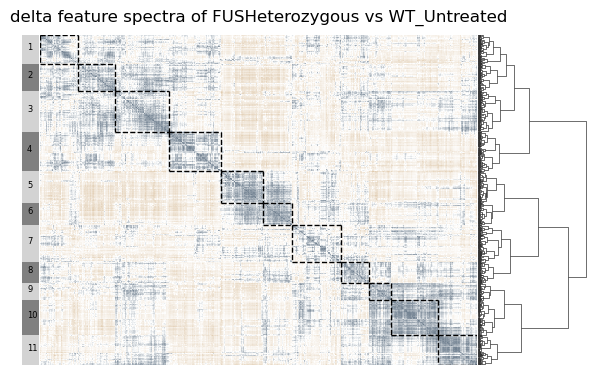

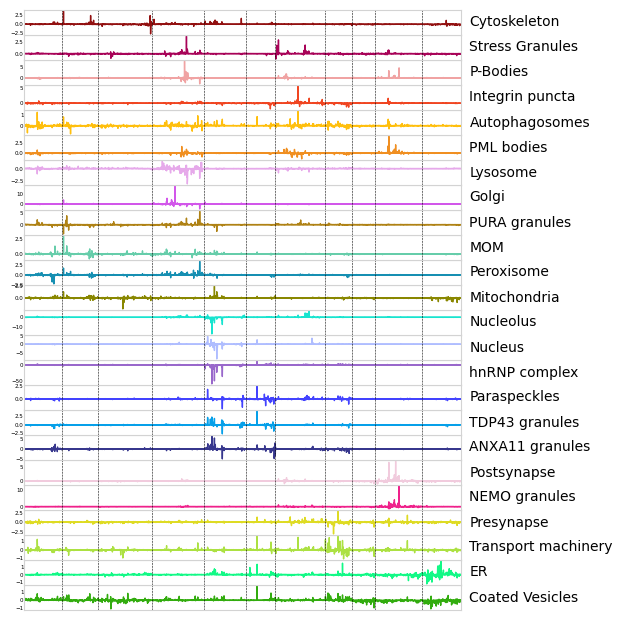

Phalloidin
G3BP1
DCP1A
CD41
SQSTM1
PML
LAMP1
GM130
PURA
TOMM20
PEX14
mitotracker
NCL
DAPI
FUS
NONO
TDP43
ANXA11
PSD95
NEMO
SCNA
KIF5A
Calreticulin
CLTC


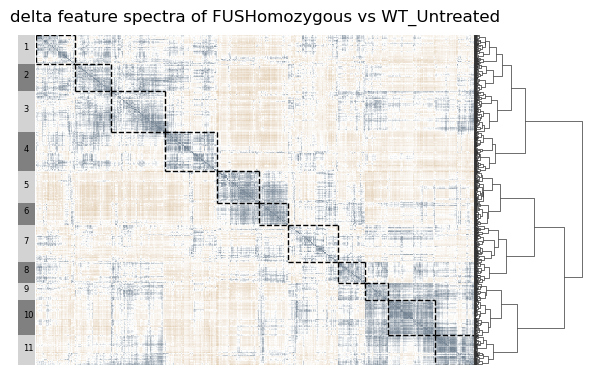

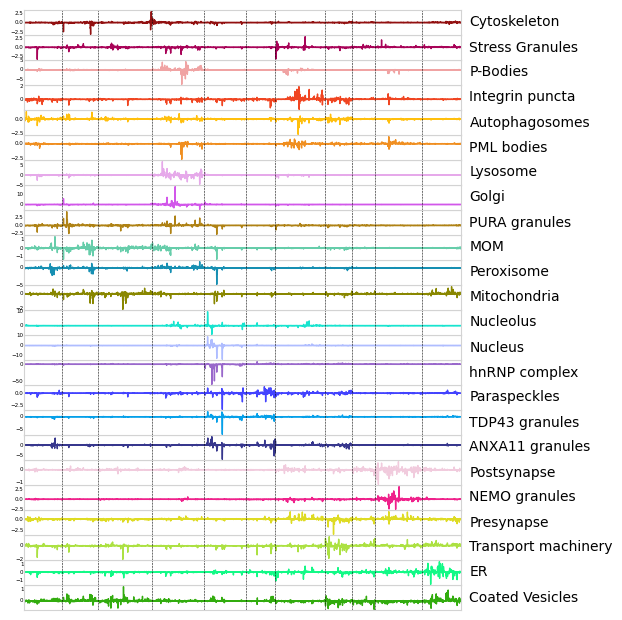

Phalloidin
G3BP1
DCP1A
CD41
SQSTM1
PML
LAMP1
GM130
PURA
TOMM20
PEX14
mitotracker
NCL
DAPI
FUS
NONO
TDP43
ANXA11
PSD95
NEMO
SCNA
KIF5A
Calreticulin
CLTC


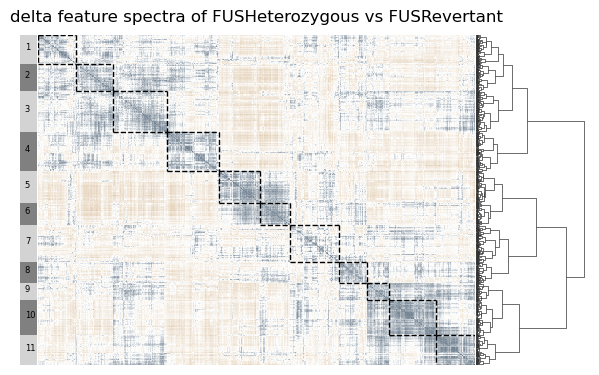

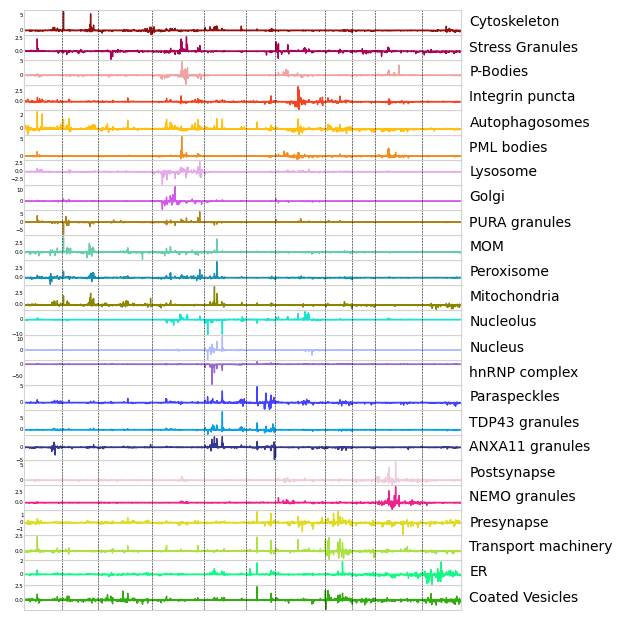

Phalloidin
G3BP1
DCP1A
CD41
SQSTM1
PML
LAMP1
GM130
PURA
TOMM20
PEX14
mitotracker
NCL
DAPI
FUS
NONO
TDP43
ANXA11
PSD95
NEMO
SCNA
KIF5A
Calreticulin
CLTC


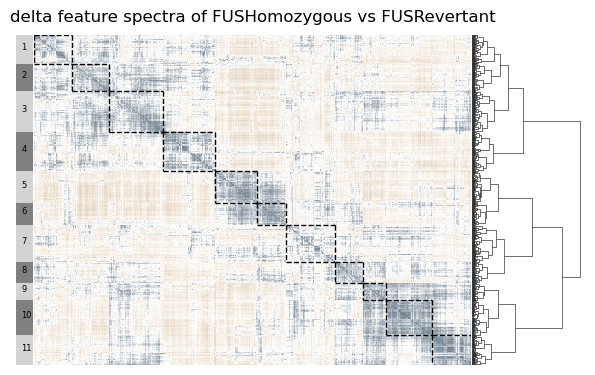

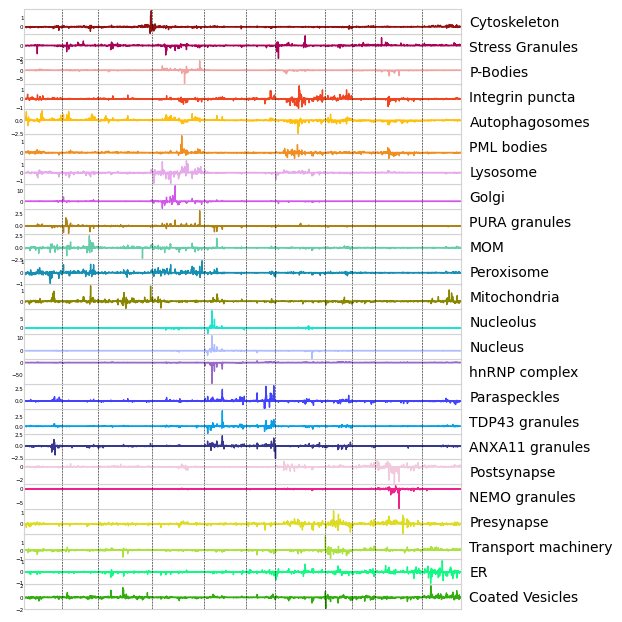

In [133]:
# #not used in the end
# for first_cond, second_cond in zip(['FUSHeterozygous', 'FUSHomozygous','FUSHeterozygous', 'FUSHomozygous'],['WT_Untreated','WT_Untreated','FUSRevertant','FUSRevertant']):
#     ## Prepare data for hisograms (first vs second)
#     cur_pair_df = hist_df_all[hist_df_all.label.str.contains(f'{first_cond}|{second_cond}', regex=True)]
#     cur_pair_df = cur_pair_df.drop(columns='path')
#     # markers = ['FUS','ANXA11']
#     # cur_pair_df = cur_pair_df[cur_pair_df.label.str.contains('ANXA11|FUS_', regex=True)]
#     cur_pair_df = cur_pair_df[~cur_pair_df.label.str.contains('FMRP|TIA1', regex=True)]

#     cur_pair_df['label'] = cur_pair_df['label'].str.split("_").str[0:2].apply(lambda x: '_'.join(x)) # merging different batches and reps -> label == marker_cellline
#     # analyse_deltas(cur_pair_df, first_cond=first_cond, second_cond=second_cond.replace("_Untreated",""), 
#     #               graph_filename=None, save_path=SAVE_PATH_fig3, 
#     #                to_save=False, plot_network=True, scale_factor=4, corr_method='spearman')
#     plot_heatmap_with_clusters_and_histograms(corr_with_clusters.sort_index(), cur_pair_df, labels=marker_order, 
#                                           to_save=False, #colors = {first_cond: "#52C5D5", second_cond.replace("_Untreated",""): "#F7810F"},
#                                           save_path=None, plot_delta=True, color_by_cond=False, 
#                                          first_cond=first_cond, sep_histograms=True, plot_hists=False,
#                                               second_cond=second_cond.replace("_Untreated",""), 
#                                               title=f'delta feature spectra of {first_cond} vs {second_cond}', 
#                                               calc_linkage=True, linkage_method='ward')
    

# Stupid colorbar

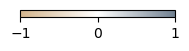

In [161]:
clustermap_colors = LinearSegmentedColormap.from_list("", ["tan", "white", "slategray"])

fig, ax = plt.subplots(figsize=(2, 0.1))

# Set the colorbar range and colormap
norm = plt.Normalize(-1, 1)
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=clustermap_colors), cax=ax, orientation='horizontal', ticks=[-1, 0, 1])

# Save the figure
fig.savefig('horizontal_colorbar.eps', bbox_inches='tight')